In [1]:
%config Completer.use_jedi=False

In [2]:
import numpy as np

In [3]:
from itertools import chain, groupby

In [4]:
from collections import Counter

In [5]:
import string

In [6]:
import time

In [7]:
import re

In [8]:
import gc

In [9]:
from sklearn.manifold import TSNE

In [10]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

In [11]:
from tqdm.notebook import trange, tqdm

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [14]:
from sklearn.decomposition import PCA

In [15]:
from IPython.display import HTML
import plotly.express as px

In [16]:
torch.manual_seed(8912323)

In [17]:
%load_ext line_profiler

-------------------------------------------------------------------

-------------------------------------------------------------------

In [18]:
def generate_word_contextword_pairs(sentence, window_size=5): 
    all_word_context_pairs = []
    
    for i, word in enumerate(sentence):
#         win_size = np.random.randint(low = 1, high = window_size+1 )
        win_size = window_size
        contexts = sentence[i-win_size:i] + sentence[i+1:i+win_size+1]
        all_word_context_pairs.append([(word, context_word) for context_word in contexts])
    return list(chain.from_iterable(all_word_context_pairs))

def generate_word_contextword_pairs_dynamic(sentence, window_size=5): 
    # window size is dynamic. window_size parameter is the maximum allowed window_size.
    # so for each word, win_size is uniformly sampled from [1, window_size]
    # Ref: Goldberg and Levy 2014 

    all_word_context_pairs = []
    
    for i, word in enumerate(sentence):
        win_size = np.random.randint(low = 1, high = window_size+1 )
#         win_size = window_size
        contexts = sentence[i-win_size:i] + sentence[i+1:i+win_size+1]
        all_word_context_pairs.append([(word, context_word) for context_word in contexts])
    return list(chain.from_iterable(all_word_context_pairs))

In [19]:
corpus = torch.load('teWikiCorpus.pkl')

In [20]:
unigram_freq = Counter(list(chain.from_iterable(corpus)))

In [21]:
vocab_w = list(unigram_freq.keys())
vocab_w.insert(0, '<unk>')
vocab_w_size = len(vocab_w)

In [22]:
# corpus

In [23]:
# generate character ngrams for each word
# Ref: page 3 of  Enriching Word Vectors with Subword Information
# https://arxiv.org/pdf/1607.04606.pdf

# with hash
def extract_ngrams(str, n1, n2=None):
    if n2 is None:
        nv= [n1]
    else:
        nv = np.arange(n1, n2)

    str = '<'+str+'>'
    n_grams =[]
    for n in nv:
        for i in np.arange(len(str)-n+1):
            n_grams.append(hash(str[i:i+n]))
    n_grams.append(hash(str))
    return list(set(n_grams))

# without hash
def extract_ngrams_nohash(str, n1, n2=None):
    if n2 is None:
        nv= [n1]
    else:
        nv = np.arange(n1, n2)

    str = '<'+str+'>'
    n_grams =[]
    for n in nv:
        for i in np.arange(len(str)-n+1):
            n_grams.append(str[i:i+n])
    n_grams.append(str)
    return list(set(n_grams))


In [24]:
# extract_ngrams_nohash('విస్తీర్ణంలో', 1000)

In [25]:
char_ngrams_dict = {}
for word in vocab_w:
    char_ngrams_dict.update({word:extract_ngrams(word,3,7)})

In [26]:
# char_ngrams_dict['రెండవ']

In [27]:
vocab = set(chain.from_iterable(char_ngrams_dict.values()))

In [28]:
vocab_size  = len(vocab)

In [29]:
vocab_freq = torch.Tensor(list(unigram_freq.values()))

In [30]:
# vocab_freq = vocab_freq/vocab_freq.sum()

In [31]:
sampling_dist = vocab_freq**0.75

In [32]:
sampling_dist = sampling_dist/sampling_dist.sum()

In [33]:
word_to_idx = {word: i for i, word in enumerate(vocab_w)}
indx_to_word = {i: word for i, word in enumerate(vocab_w)}

In [34]:
subword_to_idx = {word: i for i, word in enumerate(vocab)}
indx_to_subword = {i: word for i, word in enumerate(vocab)}

In [35]:
word_indx_to_char=[]
for i in range(len(indx_to_word)):
#     word_indx_to_char.append(torch.IntTensor([subword_to_idx[subword] for subword in char_ngrams_dict[indx_to_word[i]]]).long())
    word_indx_to_char.append([subword_to_idx[subword] for subword in char_ngrams_dict[indx_to_word[i]]])

In [36]:
word_indx_to_char[1]

[45869]

In [37]:
# generate_word_contextword_pairs generate_word_contextword_pairs(sentence, n_of_ngram=3):
#     n = n_of_ngram
#     indx = int((n_of_ngram-1)/2)
#     all_word_context_pairs = []
#     for i in np.arange(len(sentence)-n + 1):
#         all_word_context_pairs.append([(sentence[i+indx], context_word) for context_word in sentence[i:i+indx]])
#         all_word_context_pairs.append([(sentence[i+indx], context_word) for context_word in sentence[i+indx+1:i+n]])
    
#     return list(chain.from_iterable(all_word_context_pairs))

# def generate_word_contextword_pairs(sentence, window_size=5): 
#     all_word_context_pairs = []
#     for i in np.arange(window_size, len(sentence)-window_size):
#         all_word_context_pairs.append([(sentence[i], context_word) for context_word in sentence[i-window_size:i]])
#         all_word_context_pairs.append([(sentence[i], context_word) for context_word in sentence[i+1:i+window_size+1]])
    
#     return list(chain.from_iterable(all_word_context_pairs))

def generate_word_contextword_pairs(sentence, window_size=5): 
    all_word_context_pairs = []
    
    for i, word in enumerate(sentence):
#         win_size = np.random.randint(low = 1, high = window_size+1 )
        win_size = window_size
        contexts = sentence[i-win_size:i] + sentence[i+1:i+win_size+1]
        all_word_context_pairs.append([(word, context_word) for context_word in contexts])
    return list(chain.from_iterable(all_word_context_pairs))

def generate_word_contextword_pairs_dynamic(sentence, window_size=5): 
    # window size is dynamic. window_size parameter is the maximum allowed window_size.
    # so for each word, win_size is uniformly sampled from [1, window_size]
    # Ref: Goldberg and Levy 2014 

    all_word_context_pairs = []
    
    for i, word in enumerate(sentence):
        win_size = np.random.randint(low = 1, high = window_size+1 )
#         win_size = window_size
        contexts = sentence[i-win_size:i] + sentence[i+1:i+win_size+1]
        all_word_context_pairs.append([(word, context_word) for context_word in contexts])
    return list(chain.from_iterable(all_word_context_pairs))

In [38]:
# data_sh = list(chain.from_iterable([generate_word_contextword_pairs_dynamic(sentence,2) for sentence in corpus]))
win_size=2
data_sh = list(chain.from_iterable([generate_word_contextword_pairs(sentence,win_size) for sentence in corpus]))
data = [(word_to_idx[a], word_to_idx[b]) for a,b in data_sh]


In [39]:
# data = [(torch.IntTensor([subword_to_idx[subword] for subword in char_ngrams_dict[a]])  , torch.IntTensor([word_to_idx[b]])) for a,b in data_sh[:10000]]

In [40]:
# data_chars = []
# data = []
# i=0
# for a,b in data_sh:
#     data.append((i , torch.IntTensor([word_to_idx[b]])) )
#     data_chars.append(torch.IntTensor([subword_to_idx[subword] for subword in char_ngrams_dict[a]]) )
#     i +=1

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [42]:
# class FastTextTorch(nn.Module):
    
#     def __init__(self,embedding_size, in_vocab_size,out_vocab_size, num_neg_samples,char_ngrams_dict, sampling_weights=None):
#         super(FastTextTorch, self).__init__()
#         self.input_embedding = nn.Embedding(in_vocab_size,embedding_size)
#         self.output_embedding = nn.Embedding(out_vocab_size, embedding_size)
        
# #         r = 0.01/embedding_size
# #         r = 5
# #         torch.nn.init.uniform_(self.input_embedding.weight, -r, r)
# #         torch.nn.init.uniform_(self.output_embedding.weight, -r, r)
#         self.in_vocab_size = in_vocab_size
#         self.out_vocab_size = out_vocab_size
#         self.embedding_size = embedding_size      
#         self.num_neg_samples = num_neg_samples
#         self.char_ngrams_dict = char_ngrams_dict
#         if sampling_weights is not None:
#             self.sampling_weights = sampling_weights
#         else:
#             self.sampling_weights = torch.ones(self.out_vocab_size)/self.out_vocab_size
            
#     def get_input_embedding(self,inp):
#         return torch.Tensor([model.input_embedding(data_chars[w].to(device)).sum(0) for w in inp])
#     def forward(self, inputs, outputs):
#         # Dont need forward. Computing loss dirictly is simpler
# #         raise NotImplementedError
        
#         inp_em =  [self.input_embedding(data_chars[w].to(device)).sum(0) for w in inputs]
#         out_em = self.output_embedding(outputs) 
#         out = torch.zeros((inputs.shape[0]))
#         for i in torch.arange(inputs.shape[0]):
#             out[i] = torch.sum(inp_em[i]*out_em[i])
        
        
# #         for _ in out.shape[1:]:
# #             out= out.sum(1)
#         return out
# #         return out.sum(1)
    
#     def negativeSampling(self, num_samples):        
#         # returns indices of sampled words
#         return torch.multinomial(self.sampling_weights, num_samples, replacement=True)
    
#     def loss(self, inputs, outputs, negative_samples):
#         # Ref: Distributed Representations of Words and Phrasesand their Compositionality
        
# #         negative_samples = self.negativeSampling(self.num_neg_samples*inputs.shape[0]) # batch size = inputs.shape[0]
# #         negative_samples = negative_samples.reshape(inputs.shape[0],self.num_neg_samples)
# #         negative_samples = negative_samples.to(device)
#         input_em = self.input_embedding(inputs)
#         output_em = self.output_embedding(outputs)
# #         print(input_em.shape)
# #         print(output_em.shape)
#         neg_samples_em = self.output_embedding(negative_samples)
# #         print(neg_samples_em.shape/
# #         print(input_em.repeat((self.num_neg_samples,1)).shape)
#         loss_val_term1 = F.logsigmoid(torch.sum(input_em* output_em, dim=1))
#         loss_val_term2 = torch.sum(F.logsigmoid(-torch.sum((input_em.unsqueeze(1).repeat((1,self.num_neg_samples,1))*neg_samples_em), dim=2)), dim=1)
# #         print("loss_val_term1: " + str(loss_val_term1.sum()) + " || loss_val_term2: " + str(loss_val_term2.sum()))
# #         print(torch.mean(loss_val_term1 + loss_val_term2))
# #         print(loss_val_term1.mean()+loss_val_term2.mean())
#         return -torch.sum(loss_val_term1 + loss_val_term2)

    
    
    

In [43]:
# class FastTextTorch(nn.Module):
    
#     def __init__(self,embedding_size, in_vocab_size,out_vocab_size, num_neg_samples,char_ngrams_dict):
#         super(FastTextTorch, self).__init__()
#         self.input_embedding = nn.Linear(in_vocab_size,embedding_size)
#         self.output_embedding = nn.Embedding(out_vocab_size, embedding_size)
        
# #         r = 0.01/embedding_size
# #         r = 5
# #         torch.nn.init.uniform_(self.input_embedding.weight, -r, r)
# #         torch.nn.init.uniform_(self.output_embedding.weight, -r, r)
#         self.in_vocab_size = in_vocab_size
#         self.out_vocab_size = out_vocab_size
#         self.embedding_size = embedding_size      
#         self.num_neg_samples = num_neg_samples
        
#     def forward(self, inputs, outputs):        
#         input_em = self.input_embedding(inputs)
#         output_em = self.output_embedding(outputs)
#         out = input_em*output_em
#         return out.sum(1)
    
#     def negativeSampling(self, num_samples,sampling_weights):        
#         # returns indices of sampled words
#         return torch.multinomial(sampling_weights, num_samples, replacement=True)
    
#     def loss(self, inputs, outputs, negative_samples):
#         # Ref: Distributed Representations of Words and Phrasesand their Compositionality
        
# #         negative_samples = self.negativeSampling(self.num_neg_samples*inputs.shape[0]) # batch size = inputs.shape[0]
# #         negative_samples = negative_samples.reshape(inputs.shape[0],self.num_neg_samples)
# #         negative_samples = negative_samples.to(device)
#         input_em = self.input_embedding(inputs)
#         output_em = self.output_embedding(outputs)
# #         print(input_em.shape)
# #         print(output_em.shape)
#         neg_samples_em = self.output_embedding(negative_samples)
# #         print(neg_samples_em.shape/
# #         print(input_em.repeat((self.num_neg_samples,1)).shape)
#         loss_val_term1 = F.logsigmoid(torch.sum(input_em* output_em, dim=1))
#         loss_val_term2 = torch.sum(F.logsigmoid(-torch.sum((input_em.unsqueeze(1).repeat((1,self.num_neg_samples,1))*neg_samples_em), dim=2)), dim=1)
# #         print("loss_val_term1: " + str(loss_val_term1.sum()) + " || loss_val_term2: " + str(loss_val_term2.sum()))
# #         print(torch.mean(loss_val_term1 + loss_val_term2))
# #         print(loss_val_term1.mean()+loss_val_term2.mean())
#         return -torch.sum(loss_val_term1 + loss_val_term2)

In [44]:
# class FastTextTorch(nn.Module):
    
#     def __init__(self,embedding_size, in_vocab_size,out_vocab_size, num_neg_samples,char_ngrams_dict):
#         super(FastTextTorch, self).__init__()
#         self.input_embedding = nn.Embedding(in_vocab_size,embedding_size)
#         self.output_embedding = nn.Embedding(out_vocab_size, embedding_size)
        
# #         r = 0.01/embedding_size
# #         r = 5
# #         torch.nn.init.uniform_(self.input_embedding.weight, -r, r)
# #         torch.nn.init.uniform_(self.output_embedding.weight, -r, r)
#         self.in_vocab_size = in_vocab_size
#         self.out_vocab_size = out_vocab_size
#         self.embedding_size = embedding_size      
#         self.num_neg_samples = num_neg_samples
        
#     def forward(self, inputs, outputs): 
        
#         inp_em = torch.zeros((outputs.shape[0], self.embedding_size), device=device)
#         for i,w in enumerate(inputs):
#             inp_em[i,:] = self.input_embedding(w).sum(0)

#         output_em = self.output_embedding(outputs)
#         return (inp_em*output_em).sum(1)
    
#     def negativeSampling(self, num_samples,sampling_weights):        
#         # returns indices of sampled words
#         return torch.multinomial(sampling_weights, num_samples, replacement=True)
    
#     def loss(self, inputs, outputs, negative_samples):
#         # Ref: Distributed Representations of Words and Phrasesand their Compositionality
        
# #         negative_samples = self.negativeSampling(self.num_neg_samples*inputs.shape[0]) # batch size = inputs.shape[0]
# #         negative_samples = negative_samples.reshape(inputs.shape[0],self.num_neg_samples)
# #         negative_samples = negative_samples.to(device)
#         input_em = self.input_embedding(inputs)
#         output_em = self.output_embedding(outputs)
# #         print(input_em.shape)
# #         print(output_em.shape)
#         neg_samples_em = self.output_embedding(negative_samples)
# #         print(neg_samples_em.shape/
# #         print(input_em.repeat((self.num_neg_samples,1)).shape)
#         loss_val_term1 = F.logsigmoid(torch.sum(input_em* output_em, dim=1))
#         loss_val_term2 = torch.sum(F.logsigmoid(-torch.sum((input_em.unsqueeze(1).repeat((1,self.num_neg_samples,1))*neg_samples_em), dim=2)), dim=1)
# #         print("loss_val_term1: " + str(loss_val_term1.sum()) + " || loss_val_term2: " + str(loss_val_term2.sum()))
# #         print(torch.mean(loss_val_term1 + loss_val_term2))
# #         print(loss_val_term1.mean()+loss_val_term2.mean())
#         return -torch.sum(loss_val_term1 + loss_val_term2)

In [45]:
def get_inp_and_offsets(inputs):
    aa = []
    offsets = [0]
    for lst in inputs:
#         tmp = word_indx_to_char[lst].numpy()
        tmp = word_indx_to_char[lst]
        aa.append(tmp)
        offsets.append(len(tmp)+offsets[-1])
    offsets.pop(-1)
    return torch.tensor(list(chain.from_iterable(aa))).to(device), torch.tensor(offsets).to(device)

In [181]:
class FastTextTorch(nn.Module):
    
    def __init__(self,embedding_size, in_vocab_size,out_vocab_size, num_neg_samples,char_ngrams_dict):
        super(FastTextTorch, self).__init__()
        self.input_embedding = nn.EmbeddingBag(in_vocab_size,embedding_size)
        self.output_embedding = nn.Embedding(out_vocab_size, embedding_size)
        
#         r = 0.01/embedding_size
#         r = 5
#         torch.nn.init.uniform_(self.input_embedding.weight, -r, r)
#         torch.nn.init.uniform_(self.output_embedding.weight, -r, r)
        self.in_vocab_size = in_vocab_size
        self.out_vocab_size = out_vocab_size
        self.embedding_size = embedding_size      
        self.num_neg_samples = num_neg_samples
        
    def forward(self, inputs, outputs):        
        inp, offsets = get_inp_and_offsets(inputs)
        input_em = self.input_embedding(inp, offsets)
        output_em = self.output_embedding(outputs)
        out = input_em*output_em
        return out.sum(1)
    
    def negativeSampling(self, num_samples,sampling_weights):        
        # returns indices of sampled words
        return torch.multinomial(sampling_weights, num_samples, replacement=True)
    
    def loss(self, inputs, outputs, negative_samples):
        # Ref: Distributed Representations of Words and Phrasesand their Compositionality
        
#         negative_samples = self.negativeSampling(self.num_neg_samples*inputs.shape[0]) # batch size = inputs.shape[0]
#         negative_samples = negative_samples.reshape(inputs.shape[0],self.num_neg_samples)
#         negative_samples = negative_samples.to(device)
        input_em = self.input_embedding(inputs)
        output_em = self.output_embedding(outputs)
#         print(input_em.shape)
#         print(output_em.shape)
        neg_samples_em = self.output_embedding(negative_samples)
#         print(neg_samples_em.shape/
#         print(input_em.repeat((self.num_neg_samples,1)).shape)
        loss_val_term1 = F.logsigmoid(torch.sum(input_em* output_em, dim=1))
        loss_val_term2 = torch.sum(F.logsigmoid(-torch.sum((input_em.unsqueeze(1).repeat((1,self.num_neg_samples,1))*neg_samples_em), dim=2)), dim=1)
#         print("loss_val_term1: " + str(loss_val_term1.sum()) + " || loss_val_term2: " + str(loss_val_term2.sum()))
#         print(torch.mean(loss_val_term1 + loss_val_term2))
#         print(loss_val_term1.mean()+loss_val_term2.mean())
        return -torch.sum(loss_val_term1 + loss_val_term2)

In [182]:
# class FastTextTorch(nn.Module):
    
#     def __init__(self,embedding_size, in_vocab_size,out_vocab_size, num_neg_samples,char_ngrams_dict, sampling_weights):
#         super(FastTextTorch, self).__init__()
#         self.input_embedding = nn.Linear(in_vocab_size,embedding_size, bias=False)
#         self.output_embedding = nn.Embedding(out_vocab_size, embedding_size)
        
# #         r = 0.01/embedding_size
# #         r = 5
# #         torch.nn.init.uniform_(self.input_embedding.weight, -r, r)
# #         torch.nn.init.uniform_(self.output_embedding.weight, -r, r)
#         self.in_vocab_size = in_vocab_size
#         self.out_vocab_size = out_vocab_size
#         self.embedding_size = embedding_size      
#         self.num_neg_samples = num_neg_samples
#         self.sampling_weights = sampling_weights
        
#     def forward(self, inputs, outputs): 
        
#         inp_em = self.input_embedding(inputs)
#         output_em = self.output_embedding(outputs)
#         return (inp_em*output_em).sum(1)
    
#     def negativeSampling(self, num_samples,sampling_weights):        
#         # returns indices of sampled words
# #         out = torch.zeros(num_samples, device=device, dtype=torch.int64)
# #         torch.multinomial(self.sampling_weights, num_samples, replacement=True, out=out)
# #         return out
#         return torch.multinomial(self.sampling_weights, num_samples, replacement=True)
    
#     def loss(self, inputs, outputs, negative_samples):
#         # Ref: Distributed Representations of Words and Phrasesand their Compositionality
        
# #         negative_samples = self.negativeSampling(self.num_neg_samples*inputs.shape[0]) # batch size = inputs.shape[0]
# #         negative_samples = negative_samples.reshape(inputs.shape[0],self.num_neg_samples)
# #         negative_samples = negative_samples.to(device)
#         input_em = self.input_embedding(inputs)
#         output_em = self.output_embedding(outputs)
# #         print(input_em.shape)
# #         print(output_em.shape)
#         neg_samples_em = self.output_embedding(negative_samples)
# #         print(neg_samples_em.shape/
# #         print(input_em.repeat((self.num_neg_samples,1)).shape)
#         loss_val_term1 = F.logsigmoid(torch.sum(input_em* output_em, dim=1))
#         loss_val_term2 = torch.sum(F.logsigmoid(-torch.sum((input_em.unsqueeze(1).repeat((1,self.num_neg_samples,1))*neg_samples_em), dim=2)), dim=1)
# #         print("loss_val_term1: " + str(loss_val_term1.sum()) + " || loss_val_term2: " + str(loss_val_term2.sum()))
# #         print(torch.mean(loss_val_term1 + loss_val_term2))
# #         print(loss_val_term1.mean()+loss_val_term2.mean())
#         return -torch.sum(loss_val_term1 + loss_val_term2)

In [183]:
# torch.index_select(model.input_embedding.weight,0, torch.IntTensor(word_indx_to_char[word_indx[0]]).to(device)).sum(0)

In [184]:
len(data)/1000

6610.19

In [242]:
model = FastTextTorch(embedding_size=100, in_vocab_size=vocab_size,out_vocab_size=vocab_w_size, char_ngrams_dict=char_ngrams_dict, num_neg_samples=5)

In [243]:
model = model.to(device)

In [52]:
# class CorpusDataset(torch.utils.data.Dataset):
#     """Face Landmarks dataset."""

#     def __init__(self, data, transform=None):
        
#         self.data = data
# #         self.transform = transform
        
#     def transform(self,x):
#         r = torch.zeros(model.in_vocab_size)
#         r[word_indx_to_char[x]] = 1
#         return r

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         sample = data[idx]

#         if self.transform:
#             sample = (self.transform(sample[0]), torch.tensor(sample[1]))

#         return sample

In [221]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gc.collect()
torch.cuda.empty_cache()
# data = data[:10000]
# device ='cpu'
nb=500
lr =0.01
n_epochs = 300
gc.collect()
torch.cuda.empty_cache()

# training
model = model.to(device)
model.train()
loss_values =[]
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# optimizer = torch.optim.LBFGS(model_N.parameters())
dataloader = torch.utils.data.DataLoader(data, batch_size=int(len(data)/nb), shuffle=True) # 
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda= lambda epoch_i_dl: (1-epoch_i_dl/(len(dataloader)*n_epochs)))
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[ 100, 150, 200], gamma=0.1)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
#                                                 max_lr=0.025, 
#                                                 steps_per_epoch=len(dataloader), 
# #                                                 anneal_strategy = 'linear',
#                                                 epochs=n_epochs
#                                                )
loss_func = nn.BCEWithLogitsLoss(reduction='sum')

# dataloader = torch.utils.data.DataLoader(CorpusDataset(data[:10000]), batch_size=64, shuffle=True, num_workers=8)

In [222]:
len(dataloader)

501

In [223]:
len(data)

6610190

In [224]:
len(indx_to_word)

8916

In [225]:
len(word_indx_to_char)

8916

In [226]:
def getInputVector(inp_word_indx):
    # inp: batch_size x 1
    inp_vec = torch.zeros(inp_word_indx.shape[0], len(subword_to_idx))
    
    for i,word_i in enumerate(inp_word_indx):
        inp_vec[i,word_indx_to_char[word_i].long()] = 1
    
#     for i,word_i in enumerate(inp):
#         for subword in char_ngrams_dict[indx_to_word[word_i.item()]]:
#             inp_vec[i,subword_to_idx[subword]] = 1
    return inp_vec
    
    

In [227]:
# def getInputVector(inp):
#     # inp: batch_size x 1
#     inp_vec = torch.zeros(inp.shape[0], len(subword_to_idx))
#     for i,word_i in enumerate(inp):
#         for subword in char_ngrams_dict[indx_to_word[word_i.item()]]:
#             inp_vec[i,subword_to_idx[subword]] = 1
#     return inp_vec
    
    

In [228]:
def get_inp_and_offsets_transform(inputs):
    aa = []
    offsets = [0]
    for lst in inputs:
#         tmp = word_indx_to_char[lst].numpy()
        tmp = word_indx_to_char[lst]
        aa.append(tmp)
        offsets.append(len(tmp)+offsets[-1])
    offsets.pop(-1)
    return (torch.tensor(list(chain.from_iterable(aa))), torch.tensor(offsets))

In [229]:
data_sh = list(chain.from_iterable([generate_word_contextword_pairs_dynamic(sentence,win_size) for sentence in corpus]))
data = [(word_to_idx[a], word_to_idx[b]) for a,b in data_sh]

In [230]:
dataloader = torch.utils.data.DataLoader(data, batch_size=int(len(data)/nb), shuffle=True) #int(len(data)/nb)

In [231]:
# dataloader = torch.utils.data.DataLoader(CorpusDataset(data[:100000]), batch_size=1024, shuffle=True)

In [232]:
# word_indx, context_word_indx = next(iter(dataloader))

In [233]:
gc.collect()
torch.cuda.empty_cache()
# dataloader = torch.utils.data.DataLoader(CorpusDataset(data[:100000]), batch_size=1024, shuffle=True,num_workers=8)

In [234]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [235]:
max([10,1])

10

In [236]:
lr0=0.01

In [244]:
loss_values =[]
def train(model, n_epochs):
    start = time.time()
    gc.collect()
    torch.cuda.empty_cache()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr0)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda= lambda epoch_i_dl: max([0.0001, 1-epoch_i_dl/(nb*n_epochs)]))
    for epoch in trange(n_epochs):
        loss_total = 0

        data_sh = list(chain.from_iterable([generate_word_contextword_pairs_dynamic(sentence,win_size) for sentence in corpus]))
        data = [(word_to_idx[a], word_to_idx[b]) for a,b in data_sh]
        dataloader = torch.utils.data.DataLoader(data, batch_size=int(len(data)/nb), shuffle=True) 
#         dataloader = torch.utils.data.DataLoader(data[:100000], batch_size=int(len(data)/nb), shuffle=True) #int(len(data)/nb)
                # zero the gradients
    #     optimizer.zero_grad()     
        
       
        i_dl=0
        for word_indx, context_word_indx in dataloader:

    #         # zero the gradients
    #         loss.zero_grad()
            optimizer.zero_grad()    

            # compute loss
            
#             inp = word_indx.to(device)
            outp = context_word_indx.to(device)
            
    #             inp = [word_indx_to_char[w].to(device) for w in word_indx]
#             inp = word_indx.numpy()
            inp = word_indx.tolist()
#             inp = word_indx.to(device)
    #             inp = getInputVector(word_indx)
    #             inp =inp.to(device)
#             outp = context_word_indx.to(device)
    #         inp = torch.IntTensor([word_indx])
    #         outp = torch.IntTensor([context_word_indx])
         # pred 
    #         negative_samples = model.negativeSampling(model.num_neg_samples*inp.shape[0]) # batch size = inputs.shape[0]
    #         negative_samples = negative_samples.reshape(inp.shape[0],model.num_neg_samples)
    #         negative_samples = negative_samples.to(device)

    #         loss = model.loss(inp, outp,negative_samples)
            pred_p = model(inp,outp)
    # #         pred_n = model(inp.unsqueeze(1).repeat((1,model.num_neg_samples)),negative_samples)
            loss = loss_func(pred_p, pred_p*0+1)
            for _ in range(model.num_neg_samples):
                negative_samples = model.negativeSampling(outp.shape[0], sampling_dist) # batch size = inputs.shape[0]
                negative_samples = negative_samples.to(device)
                pred_n = model(inp,negative_samples)


            loss += loss_func(pred_n, pred_n*0)
            
            loss_total += loss.item()
            # backward pass
            loss.backward()


            # optimization step
            optimizer.step()
    #         model.input_embedding.weight.data -= model.input_embedding.weight.grad*lr
    #         model.output_embedding.weight.data -= model.output_embedding.weight.grad*lr
    #         model.input_embedding.weight.grad.zero_()
    #         model.output_embedding.weight.grad.zero_()

            scheduler.step()
            
#             epoch_i_dl = (epoch+1)*(i_dl+1)
#             i_dl += 1
#             print(scheduler.get_last_lr())
#             print("i_dl: "+ str(i_dl))
#             print("epoch_i_dl: " + str(epoch_i_dl))
#             print((1-epoch_i_dl/(nb*n_epochs)))
        loss_values.append(loss_total)
    #     if epoch > 10:
    #         if (loss_values[-1] - loss_values[-2]) < 0.5*(loss_values[-2] - loss_values[-3]):
    #             lr = min([lr/2,0.0000025])
        
        if epoch%10 ==0:
            print("Epoch " + str(epoch) + " done. Loss: " + str(loss_total))
            print("Next step size: " + str(scheduler.get_last_lr()[0]))
            torch.save(model, 'saved_model_ft.pkl')
    # print(loss_values)
    # print("Epoch " + str(epoch) + " done. Loss: " + str(loss_total))
    elapsed = time.time() - start
    print(f"Model trained for {n_epochs} in {elapsed/60: .2f} minutes")
    return model

In [245]:
# %timeit word_indx_to_char[wi[1000]]

In [248]:
torch.save(model, 'saved_model_ft_100epochs_dynamic_linearLRdecay.pkl')

In [247]:
gc.collect()
torch.cuda.empty_cache()
model.to(device)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%lprun -f train  model = train(model, n_epochs=100)
# model = train(model, n_epochs=100)

Epoch 0 done. Loss: 8288001.087814331
Next step size: 0.0098998
Epoch 10 done. Loss: 4516544.004104614
Next step size: 0.0088978
Epoch 20 done. Loss: 4357115.191864014
Next step size: 0.0078958
Epoch 30 done. Loss: 4280237.81690979
Next step size: 0.006894
Epoch 40 done. Loss: 4222921.356201172
Next step size: 0.005892
Epoch 50 done. Loss: 4174373.1633911133
Next step size: 0.00489
Epoch 60 done. Loss: 4128625.9540863037
Next step size: 0.0038880000000000004
Epoch 70 done. Loss: 4086992.235687256
Next step size: 0.0028859999999999997
Epoch 80 done. Loss: 4046863.1100769043
Next step size: 0.0018840000000000003
Epoch 90 done. Loss: 4005807.1872558594
Next step size: 0.0008819999999999994

Model trained for 100 in  323.95 minutes


Timer unit: 1e-06 s

Total time: 19432.5 s
File: <ipython-input-244-c7fb9cc6475f>
Function: train at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def train(model, n_epochs):
     3         1          3.0      3.0      0.0      start = time.time()
     4         1     360706.0 360706.0      0.0      gc.collect()
     5         1         15.0     15.0      0.0      torch.cuda.empty_cache()
     6         1        121.0    121.0      0.0      optimizer = torch.optim.Adam(model.parameters(), lr = lr0)
     7         1        117.0    117.0      0.0      scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda= lambda epoch_i_dl: max([0.0001, 1-epoch_i_dl/(nb*n_epochs)]))
     8       101     328869.0   3256.1      0.0      for epoch in trange(n_epochs):
     9       100        282.0      2.8      0.0          loss_total = 0
    10                                           
    11       100 1990276378.0 199

In [67]:
# torch.index_select(model.input_embedding.weight,0, torch.IntTensor(word_indx_to_char[word_indx[0]]).to(device)).sum(0).shape

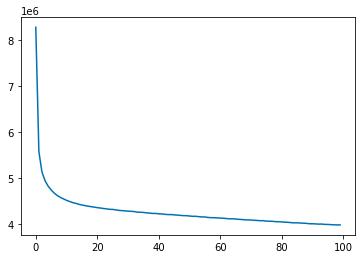

In [249]:
plt.plot(loss_values)

In [ ]:
word_indx_to_char[word_indx[0]]

In [250]:
device = 'cpu'
model.to('cpu')
# em = nn.Linear(model.in_vocab_size, model.embedding_size)

# em.weight = model.input_embedding.weight
# em.weight.requires_grad = False
# word_emb = em.weight.numpy()

em = nn.EmbeddingBag.from_pretrained(model.input_embedding.weight, freeze=True)


In [104]:
# inp, offsets = get_inp_and_offsets(torch.IntTensor([100]))

# cosineSimilarity(word_vec, em(inp, offsets).numpy().squeeze())

# word_to_idx['జిల్లా']

# em(inp, offsets).numpy().squeeze()

# word_emb.shape

In [258]:
# findSimilar('queen', word_emb,10)
# word = 'తక్కువ' #'లోపల'#'పాలు'#'సమీప'#'దివ్యాంగుల'#'జైపూర్'
word = 'పంటలు'#'నీరు'#'తక్కువ' #'పాలు'#'అన్న' #'అక్కడ' #'దేశం'
# word = 'దక్షిణ'#'తండ్రి'
# word = 'నక్షత్రం'#'బంగారు'#'విద్య'#'రాజ్యాంగం'#'ఇథియోపియా'#'బిలియన్ల'#'నదులు'#'యుద్ధం'#'మొక్కలు'#'గాంధీ'#'విజయం'#'అభివృద్ధి'
# word = 'ఎనిమిది'#'కుటుంబం'#'ఆలయ'#'సాయంత్రం'#'నక్షత్రం' #'దిగుమతి'#'పాఠశాల'#'వినియోగం'
# word = 'గ్రామం'
# word = 'ప్రముఖ'#'లక్ష'#'ప్రముఖ'#'జర్మన్'#'ప్రజలు'#'గుండె'#'మట్టి'#'ఆధిక్యత'#'చెట్లు'#'పెద్ద'#'ఆధారిత'#'ఇతర'#'జిల్లా'#'ఒకటి'#'దూరం' #'కణాలు'
# model.input_embedding.requires_grad_(False)
findSimilar_N(word, em, 10)

[('వరి', 0.5933918952941895),
 ('కూరగాయలు', 0.5736520886421204),
 ('పంటలను', 0.5348685383796692),
 ('పండు', 0.5330380797386169),
 ('విత్తనాలు', 0.5318567752838135),
 ('పత్తి', 0.5299122333526611),
 ('ప్రత్తి', 0.5249885320663452),
 ('చెరకు', 0.5114282369613647),
 ('పప్పు', 0.5006212592124939),
 ('వర్షాలు', 0.49976930022239685)]

In [161]:
# findSimilar('queen', word_emb,10)
# word = 'పది'
# word ='అన్న'
word = 'పంటలు'#'నీరు'#'తక్కువ' #'పాలు'#'అన్న' #'అక్కడ' #'దేశం'
# model.input_embedding.requires_grad_(False)
findSimilar_N(word, em, 10)

[('మంటలు', 0.6825847029685974),
 ('పాఠశాలకు', 0.6818782687187195),
 ('గంటలు', 0.6803637742996216),
 ('పంట', 0.6578326225280762),
 ('చెరుకు', 0.6567128300666809),
 ('పాటలు', 0.6536258459091187),
 ('వ్యాసాలు', 0.6505818367004395),
 ('పరిశ్రమల', 0.6488710045814514),
 ('రకరకాల', 0.6432406902313232),
 ('విశ్రాంతి', 0.6415542364120483)]

In [ ]:
inp, offsets = get_inp_and_offsets(torch.IntTensor([word_to_idx[word]]))
word_vec = em(inp, offsets)
word_vec = word_vec.detach().numpy().squeeze()

In [76]:
def findSimilar_N(word, em, k=5):
    inp, offsets = get_inp_and_offsets(torch.IntTensor([word_to_idx[word]]))
    word_vec = em(inp, offsets)
    word_vec = word_vec.detach().numpy().squeeze()

    sim = np.zeros(len(indx_to_word.keys()))
    for i,row in enumerate(indx_to_word.keys()):
        inp, offsets = get_inp_and_offsets(torch.IntTensor([row]))
        row_v = em(inp, offsets).detach().numpy().squeeze()
        sim[i] = cosineSimilarity(word_vec, row_v)

    val,ind = torch.topk(torch.Tensor(sim), k+1)
#     plt.scatter(np.arange(len(sim)),sim)
#     print(val)
#     print(ind)
#     print(row.shape)
    return [(indx_to_word[ind[i].item()], val[i].item() )for i in np.arange(1, len(ind))]

In [ ]:
def findSimilar(word, em, k=5):
    word_vec = em(getInputVector(torch.IntTensor([word_to_idx[word]])))
    word_vec = word_vec.detach().numpy().squeeze()

    sim = np.zeros(len(indx_to_word.keys()))
    for i,row in enumerate(indx_to_word.keys()):
        row_v = em(getInputVector(torch.IntTensor([row]))).detach().numpy().squeeze()
        sim[i] = cosineSimilarity(word_vec, row_v)

    val,ind = torch.topk(torch.Tensor(sim), k+1)
#     plt.scatter(np.arange(len(sim)),sim)
#     print(val)
#     print(ind)
#     print(row.shape)
    return [(indx_to_word[ind[i].item()], val[i].item() )for i in np.arange(1, len(ind))]

In [75]:
def cosineSimilarity(w1, w2):
    return np.dot(w1,w2)/(np.linalg.norm(w1) * np.linalg.norm(w2))

In [127]:
word_indx, context_word_indx = next(iter(dataloader))
# context_word_indx[0]

In [130]:
word_indx.tolist()

tensor([1876, 1751, 1678,  ..., 2829, 1511, 1808])

In [85]:
model.input_embedding.weight.shape

torch.Size([100, 77341])

In [90]:
%timeit model.input_embedding.weight[:,word_indx[0].bool()].sum(1)

114 µs ± 5.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [437]:
len(dataloader)

501

In [ ]:
len(word_indx_to_char)

In [ ]:
word_indx_to_char[1]

In [ ]:
inp_em =  [model.input_embedding(word_indx_to_char[w].to(device)).sum(0) for w in inp]

In [ ]:
inp_em[0].shape

In [ ]:
outp = context_word_indx.to(device)